# Телеком
## Задача проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

- Критерии оценки проекта «Телеком»

    Целевой признак: столбец `'EndDate'` равен `'No'`.

    Основная метрика: AUC-ROC.

    Дополнительная метрика: Accuracy.

    Критерии оценки:

    - AUC-ROC < 0.75 — 0 sp
    - 0.75 ≤ AUC-ROC < 0.81 — 4 sp
    - 0.81 ≤ AUC-ROC < 0.85 — 4.5 sp
    - 0.85 ≤ AUC-ROC < 0.87 — 5 sp
    - 0.87 ≤ AUC-ROC < 0.88 — 5.5 sp
    - AUC-ROC ≥ 0.88 — 6 sp

### Описание услуг

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).  

Также доступны такие услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных

Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

Информация о договорах актуальна на 1 февраля 2020.

## Исследовательский анализ данных

Загрузим необходимые билиотеки

In [1]:
#!pip install graphviz
#!pip install lightgbm
#!pip install catboost
#!pip install shap
#!pip install pydot
#!pip install pydotplus

In [2]:
#common
import pandas as pd
from matplotlib import pyplot as plt
from datetime import date
import importlib
import time
import numpy as np
import pydot
import graphviz
import seaborn as sns
import shap

#import keras, tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras import backend as K
from keras.metrics import categorical_accuracy
from tensorflow.keras.optimizers import Adam
from keras.callbacks import Callback, EarlyStopping
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#sklearn
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.utils import shuffle

Теперь зададим необходимые константы и откроем файлы

In [3]:
csv_path = 'c:/Users/IT/YandexDisk/Яндекс Пракиткум/Спринт 17 - Финальный проект/final_provider/'
csv_path_practicum = '/datasets/final_provider/'
rand_state=12345
np.random.seed(rand_state)

In [4]:
try:
    df_contract = pd.read_csv(csv_path+'contract.csv')
    df_internet = pd.read_csv(csv_path+'internet.csv')
    df_personal = pd.read_csv(csv_path+'personal.csv')
    df_phone = pd.read_csv(csv_path+'phone.csv')
except:
    df_contract = pd.read_csv(csv_path_practicum+'contract.csv')
    df_internet = pd.read_csv(csv_path_practicum+'internet.csv')
    df_personal = pd.read_csv(csv_path_practicumh+'personal.csv')
    df_phone = pd.read_csv(csv_path_practicum+'phone.csv')

df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_phone = pd.read_csv('/datasets/final_provider/phone.csv')

Посмотрим на каждую таблицу в отдельности. Выведем .info(), .head(), проверим уникальны ли 'customerID', проверим наличие явных пропусков

In [5]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [6]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [7]:
df_contract['customerID'].nunique()

7043

In [8]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [9]:
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [10]:
df_internet['customerID'].nunique()

5517

In [11]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [12]:
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [13]:
df_personal['customerID'].nunique()

7043

In [14]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [15]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [16]:
df_phone['customerID'].nunique()

6361

Явных пропусков нет, можно объединить данные, чтобы потом работать с одной таблицой

In [17]:
df_all = df_contract.merge(df_internet, how='left', left_on='customerID', right_on='customerID')

In [18]:
df_all = df_all.merge(df_personal, how='left', left_on='customerID', right_on='customerID')

In [19]:
df_all = df_all.merge(df_phone, how='left', left_on='customerID', right_on='customerID')

In [20]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   InternetService   5517 non-null   object 
 9   OnlineSecurity    5517 non-null   object 
 10  OnlineBackup      5517 non-null   object 
 11  DeviceProtection  5517 non-null   object 
 12  TechSupport       5517 non-null   object 
 13  StreamingTV       5517 non-null   object 
 14  StreamingMovies   5517 non-null   object 
 15  gender            7043 non-null   object 
 16  SeniorCitizen     7043 non-null   int64  


In [21]:
df_all['MonthlyCharges'].nunique()

1585

In [22]:
df_all.head(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No


Выяснилось, что в TotalCharges есть неявные пропуски в виде пробелов. Посмотрим сколько таких строк

In [23]:
df_all[df_all['TotalCharges'] == ' '].shape

(11, 20)

Всего 11 строк. Можем смело их удалить

In [24]:
df_all = df_all[df_all['TotalCharges'] != ' ']

Теперь переведем дату начала в правильный формат

In [25]:
df_all['BeginDate'] = pd.to_datetime(df_all['BeginDate'], format = '%Y-%m-%d')

Из даты окончания мы можем сделать новую фичу в виде "время жизни клиента в днях", помня про дату отчета

In [26]:
def set_total_days(row):
    date_today = pd.Timestamp('2020-02-01')
    
    if row['EndDate'] =='No':
        return (date_today-row['BeginDate']).days
    else:
        return (pd.Timestamp(row['EndDate'])-row['BeginDate']).days

df_all['DaysTotal'] = df_all.apply(set_total_days, axis=1)

In [27]:
df_all['DaysTotal'].head(5)

0      31
1    1036
2      61
3    1371
4      61
Name: DaysTotal, dtype: int64

In [28]:
df_all.pivot_table(values='PaperlessBilling', index=['Type'], aggfunc=['count'])

,count
,PaperlessBilling
Type,
Month-to-month,3875
One year,1472
Two year,1685


Так как мы уже посчитали "время жизни клиента", то EndDate можем превратить в целевуо столбец

In [29]:
df_all['EndDate'] = df_all['EndDate'].apply(lambda x: 'Yes' if x != 'No' else x)

Также приведем TotalCharges к численому значению

In [30]:
df_all['TotalCharges'] = df_all['TotalCharges'].astype('float64')

И выкидываем столбцы которые нам не нужны

In [31]:
cols_to_drop = ['customerID', 'BeginDate', 'TotalCharges']
#cols_to_drop = ['customerID', 'BeginDate', 'PaperlessBilling']

In [32]:
df_all.drop(columns=cols_to_drop, inplace=True)

In [33]:
df_all = df_all.fillna('No')

## <a id='the_destination'></a> Уточняющие вопросы

Вопросов нет

## План работ

#### Для построения модели нам потребуется:
- <i>дополнительно поискать аномалии или выбросы</i>. Вполне возможно, что на этапе подготовки данных мы что-то упустили, можно посмотреть повнимательнее, если метрика будет плохой;
- <i>закодировать фичи (Ordinal, OHE)</i>. В зависимости от выбора модели можно будет применить различные методы кодирования и посмотреть как это влияет на метрики;
- <i>возможно применить скейлинг</i>. В зависимости от выбора модели можно будет применить скейлинг и посмотреть как это влияет на метрики;
- <i>построить модель применив нужные метрики, достичь нужного значения</i>. Мы используем AUC-ROC плюс контроль по accuracy
- <i>написать вывод</i>.

## Построение моделей

### Подготовка пайплайнов и выборок

In [34]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   EndDate           7032 non-null   object 
 1   Type              7032 non-null   object 
 2   PaperlessBilling  7032 non-null   object 
 3   PaymentMethod     7032 non-null   object 
 4   MonthlyCharges    7032 non-null   float64
 5   InternetService   7032 non-null   object 
 6   OnlineSecurity    7032 non-null   object 
 7   OnlineBackup      7032 non-null   object 
 8   DeviceProtection  7032 non-null   object 
 9   TechSupport       7032 non-null   object 
 10  StreamingTV       7032 non-null   object 
 11  StreamingMovies   7032 non-null   object 
 12  gender            7032 non-null   object 
 13  SeniorCitizen     7032 non-null   int64  
 14  Partner           7032 non-null   object 
 15  Dependents        7032 non-null   object 
 16  MultipleLines     7032 non-null   object 


In [35]:
encoder = LabelEncoder()
encoder.fit(df_all['EndDate'])
df_all['EndDate'] = encoder.transform(df_all['EndDate'])

def cols_to_end(df, cols):
    return df[[c for c in df if c not in cols] + [c for c in cols if c in df]]

cols_at_end = ['EndDate']

df_all = cols_to_end(df_all, cols_at_end)

In [36]:
df_all['SeniorCitizen'] = df_all['SeniorCitizen'].astype('object')
categorical_features = df_all.drop(['EndDate'], axis=1).select_dtypes(include='object').columns
numeric_features = df_all.drop(['EndDate'], axis=1).select_dtypes(include=['float64','int64']).columns


numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OrdinalEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])


In [37]:
pipeline_col_labels = list(numeric_features)  + list(categorical_features)

In [38]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=rand_state)
    return features_upsampled, target_upsampled


def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=rand_state)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=rand_state)] + [target_ones])
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=rand_state)
    
    return features_downsampled, target_downsampled

In [39]:
def split_data(df, target_column, rand_state, upsamping_rate):
    features = df.drop([target_column], axis=1)
    target = df[target_column]
    features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=rand_state)
    #сразу применяем апсемплинг
    #features_train, target_train = upsample(features_train, target_train, upsamping_rate)
    return features_train, target_train, features_test, target_test

#df_balance = df_all.pivot_table(values='PaperlessBilling', index=['EndDate'], aggfunc=['count'])
#upsamping_rate = df_balance['count']['PaperlessBilling'][0]//df_balance['count']['PaperlessBilling'][1]


features_train, target_train, features_test, target_test = split_data(df_all, 'EndDate', rand_state, 1)

In [40]:
features_train

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,DaysTotal
1355,Month-to-month,Yes,Electronic check,19.50,No,No,No,No,No,No,No,Female,0,No,No,No,276
1744,One year,Yes,Bank transfer (automatic),104.45,Fiber optic,Yes,Yes,Yes,No,Yes,Yes,Female,0,Yes,No,No,1248
4199,One year,Yes,Electronic check,104.15,Fiber optic,No,No,Yes,Yes,Yes,Yes,Male,0,Yes,No,Yes,1675
1585,One year,No,Credit card (automatic),80.45,DSL,Yes,No,No,Yes,Yes,Yes,Male,0,Yes,No,Yes,1279
3968,Two year,No,Bank transfer (automatic),20.05,No,No,No,No,No,No,No,Female,0,Yes,No,No,2191
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3503,One year,Yes,Electronic check,104.25,Fiber optic,No,Yes,No,Yes,Yes,Yes,Male,0,No,No,Yes,2010
3498,Month-to-month,Yes,Electronic check,75.20,Fiber optic,Yes,No,No,No,No,No,Male,0,No,No,No,1309
2182,Two year,Yes,Electronic check,103.20,Fiber optic,No,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes,1706
3563,Month-to-month,Yes,Credit card (automatic),90.50,Fiber optic,Yes,No,No,No,No,Yes,Male,1,No,No,Yes,914


### Классические модели, бустинг

In [41]:
#база моделей и диапазона подбираемых гиперпараметров
data_models = [['Логистическая регрессия','sklearn.linear_model','LogisticRegression', 
                {'classifier__class_weight' : ['balanced']}],
    
               ['LightGBM','lightgbm','LGBMClassifier', 
                {'classifier__learning_rate': [0.3, 0.4, 0.5, 0.6],
                 'classifier__max_depth': range(10, 200, 20),
                 'classifier__class_weight' : ['balanced']}],
               
               ['Случайный лес','sklearn.ensemble','RandomForestClassifier',
                 {'classifier__n_estimators': [20, 40, 60, 80, 100],
                  'classifier__max_depth':  [10, 20, 30, 40],
                  'classifier__class_weight' : ['balanced']}],
               
               ['CatBoost','catboost','CatBoostClassifier',
                  {'classifier__depth'         : [6, 8],
                   'classifier__learning_rate' : [0.01, 0.05, 0.1],
                   'classifier__iterations'    : range(1000, 2000, 200),
                   'classifier__loss_function' : ['Logloss'],
                   'classifier__auto_class_weights' : ['Balanced'],
                   'classifier__verbose' : [False]}]
               ]    
models_df = pd.DataFrame(data_models, columns = ['label','module','model', 
                                                 'parameters'])
models_df

,label,module,model,parameters
0,Логистическая регрессия,sklearn.linear_model,LogisticRegression,{'classifier__class_weight': ['balanced']}
1,LightGBM,lightgbm,LGBMClassifier,"{'classifier__learning_rate': [0.3, 0.4, 0.5, ..."
2,Случайный лес,sklearn.ensemble,RandomForestClassifier,"{'classifier__n_estimators': [20, 40, 60, 80, ..."
3,CatBoost,catboost,CatBoostClassifier,"{'classifier__depth': [6, 8], 'classifier__lea..."


In [42]:
def choose_model(features_train, target_train, features_test, target_test, target_col, sampling, encoding):
    table_result = []
    for index, row in models_df.iterrows():
        #загружаем класс модели
        ModelClass = getattr(importlib.import_module(row['module']), row['model'])
        model = ModelClass()
        model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', model)])
        
        #подбираем параметры гридсерчем по метрике roc_auc
        print('Gridsearch модели:', row['label'], '...')
        start_time = time.time()
        grid = GridSearchCV(model_pipeline, row['parameters'], cv=4, 
                            scoring='roc_auc',
                            n_jobs=-1,
                            verbose=1)
        grid.fit(features_train, target_train)
        grid_time = (time.time() - start_time)/grid.n_splits_

        #вычисляем ROC-AUC на тестовых данных
        print('Тест модели: ', row['label'], '...')
        start_time = time.time()
        predicted_test = grid.best_estimator_.predict(features_test)
        roc_auc = roc_auc_score(target_test,  grid.best_estimator_.predict_proba(features_test)[:,1])
        acc = accuracy_score(target_test, predicted_test)
        precision = precision_score(target_test, predicted_test)
        recall = precision_score(target_test, predicted_test)
        
        predict_time = time.time() - start_time
        
        table_result.append([roc_auc, acc, precision, recall, sampling, encoding, grid_time, predict_time, 
                            row['label'], row['module'], row['model'], 
                            grid.best_params_, grid.best_estimator_])
    table_result = pd.DataFrame(table_result, columns = ['roc_auc','accuracy','precision', 'recall', 'sampling',
                                                       'encoding','grid time(mean fold time)', 
                                                       'predict time','label', 
                                                       'module','model', 
                                                       'optimal_parameters', 'model_obj'])
    return table_result

In [43]:
table_result = choose_model(features_train, target_train, 
                            features_test, target_test, 
                            'EndDate', 'none', 'ordinal')

Gridsearch модели: Логистическая регрессия ...
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Тест модели:  Логистическая регрессия ...
Gridsearch модели: LightGBM ...
Fitting 4 folds for each of 40 candidates, totalling 160 fits
Тест модели:  LightGBM ...
Gridsearch модели: Случайный лес ...
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Тест модели:  Случайный лес ...
Gridsearch модели: CatBoost ...
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Тест модели:  CatBoost ...


Промежуточные результаты:

In [44]:
table_result

,roc_auc,accuracy,precision,recall,sampling,encoding,grid time(mean fold time),predict time,label,module,model,optimal_parameters,model_obj
0,0.845449,0.739872,0.514431,0.514431,none,ordinal,0.524834,0.023936,Логистическая регрессия,sklearn.linear_model,LogisticRegression,{'classifier__class_weight': 'balanced'},"(ColumnTransformer(transformers=[('num',\n ..."
1,0.911794,0.852168,0.723785,0.723785,none,ordinal,1.943889,0.063829,LightGBM,lightgbm,LGBMClassifier,"{'classifier__class_weight': 'balanced', 'clas...","(ColumnTransformer(transformers=[('num',\n ..."
2,0.860021,0.789623,0.592751,0.592751,none,ordinal,1.436371,0.062930,Случайный лес,sklearn.ensemble,RandomForestClassifier,"{'classifier__class_weight': 'balanced', 'clas...","(ColumnTransformer(transformers=[('num',\n ..."
3,0.921071,0.873490,0.766234,0.766234,none,ordinal,78.120832,0.043985,CatBoost,catboost,CatBoostClassifier,"{'classifier__auto_class_weights': 'Balanced',...","(ColumnTransformer(transformers=[('num',\n ..."


### Нейронные сети (Keras)

In [45]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7032 non-null   object 
 1   PaperlessBilling  7032 non-null   object 
 2   PaymentMethod     7032 non-null   object 
 3   MonthlyCharges    7032 non-null   float64
 4   InternetService   7032 non-null   object 
 5   OnlineSecurity    7032 non-null   object 
 6   OnlineBackup      7032 non-null   object 
 7   DeviceProtection  7032 non-null   object 
 8   TechSupport       7032 non-null   object 
 9   StreamingTV       7032 non-null   object 
 10  StreamingMovies   7032 non-null   object 
 11  gender            7032 non-null   object 
 12  SeniorCitizen     7032 non-null   object 
 13  Partner           7032 non-null   object 
 14  Dependents        7032 non-null   object 
 15  MultipleLines     7032 non-null   object 
 16  DaysTotal         7032 non-null   int64  


In [46]:
#cols_to_drop = ['TechSupport', 'StreamingMovies', 'DeviceProtection', 'gender', 'Partner', 'StreamingTV', 'Dependents']
cols_to_drop = []
df_all['SeniorCitizen'] = df_all['SeniorCitizen'].astype('int64')
df_all['EndDate'] = df_all['EndDate'].astype('int64')
categorical_features = df_all.drop(['EndDate'], axis=1).select_dtypes(include='object').columns
numeric_features = df_all.drop(['EndDate'], axis=1).select_dtypes(include=['float64','int64']).columns

In [47]:
df_keras = df_all.copy()
df_keras = df_keras.rename(columns={"EndDate": "target"})

In [48]:
train, test = train_test_split(df_keras, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [49]:
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
    dataframe = dataframe.copy()
    labels = dataframe.pop('target')
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(batch_size)
    return ds

In [50]:
train_ds = df_to_dataset(train)

In [51]:
def get_normalization_layer(name, dataset):
    # делем слой для нормализации
    normalizer = preprocessing.Normalization(axis=None)
    # берем только одну нашу фичу из датасета
    feature_ds = dataset.map(lambda x, y: x[name])
    # учимся
    normalizer.adapt(feature_ds)
    return normalizer

In [52]:
def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # обрабатываем строки
    if dtype == 'string':
        index = preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = preprocessing.IntegerLookup(max_tokens=max_tokens)
    # берем только одну нашу фичу из датасета
    feature_ds = dataset.map(lambda x, y: x[name])
    index.adapt(feature_ds)
    encoder = preprocessing.CategoryEncoding(num_tokens=index.vocabulary_size())
    #применяем OneHotEncoding
    return lambda feature: encoder(index(feature))

In [53]:
batch_size = 256
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [54]:
all_inputs = []
encoded_features = []
for header in numeric_features:
    numeric_col = tf.keras.Input(shape=(1,), name=header)
    normalization_layer = get_normalization_layer(header, train_ds)
    encoded_numeric_col = normalization_layer(numeric_col)
    all_inputs.append(numeric_col)
    encoded_features.append(encoded_numeric_col)

In [55]:
for header in categorical_features:
    categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
    encoding_layer = get_category_encoding_layer(header, train_ds, dtype='string',
                                               max_tokens=5)
    encoded_categorical_col = encoding_layer(categorical_col)
    all_inputs.append(categorical_col)
    encoded_features.append(encoded_categorical_col)

In [56]:
optimizer = Adam(learning_rate=0.0009)
all_features = tf.keras.layers.concatenate(encoded_features)
x = tf.keras.layers.Dense(17, activation="relu")(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=[tf.keras.metrics.AUC(curve='ROC'),'accuracy'])

In [57]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Type (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
PaperlessBilling (InputLayer)   [(None, 1)]          0                                            
__________________________________________________________________________________________________
PaymentMethod (InputLayer)      [(None, 1)]          0                                            
__________________________________________________________________________________________________
InternetService (InputLayer)    [(None, 1)]          0                                            
______________________________________________________________________________________________

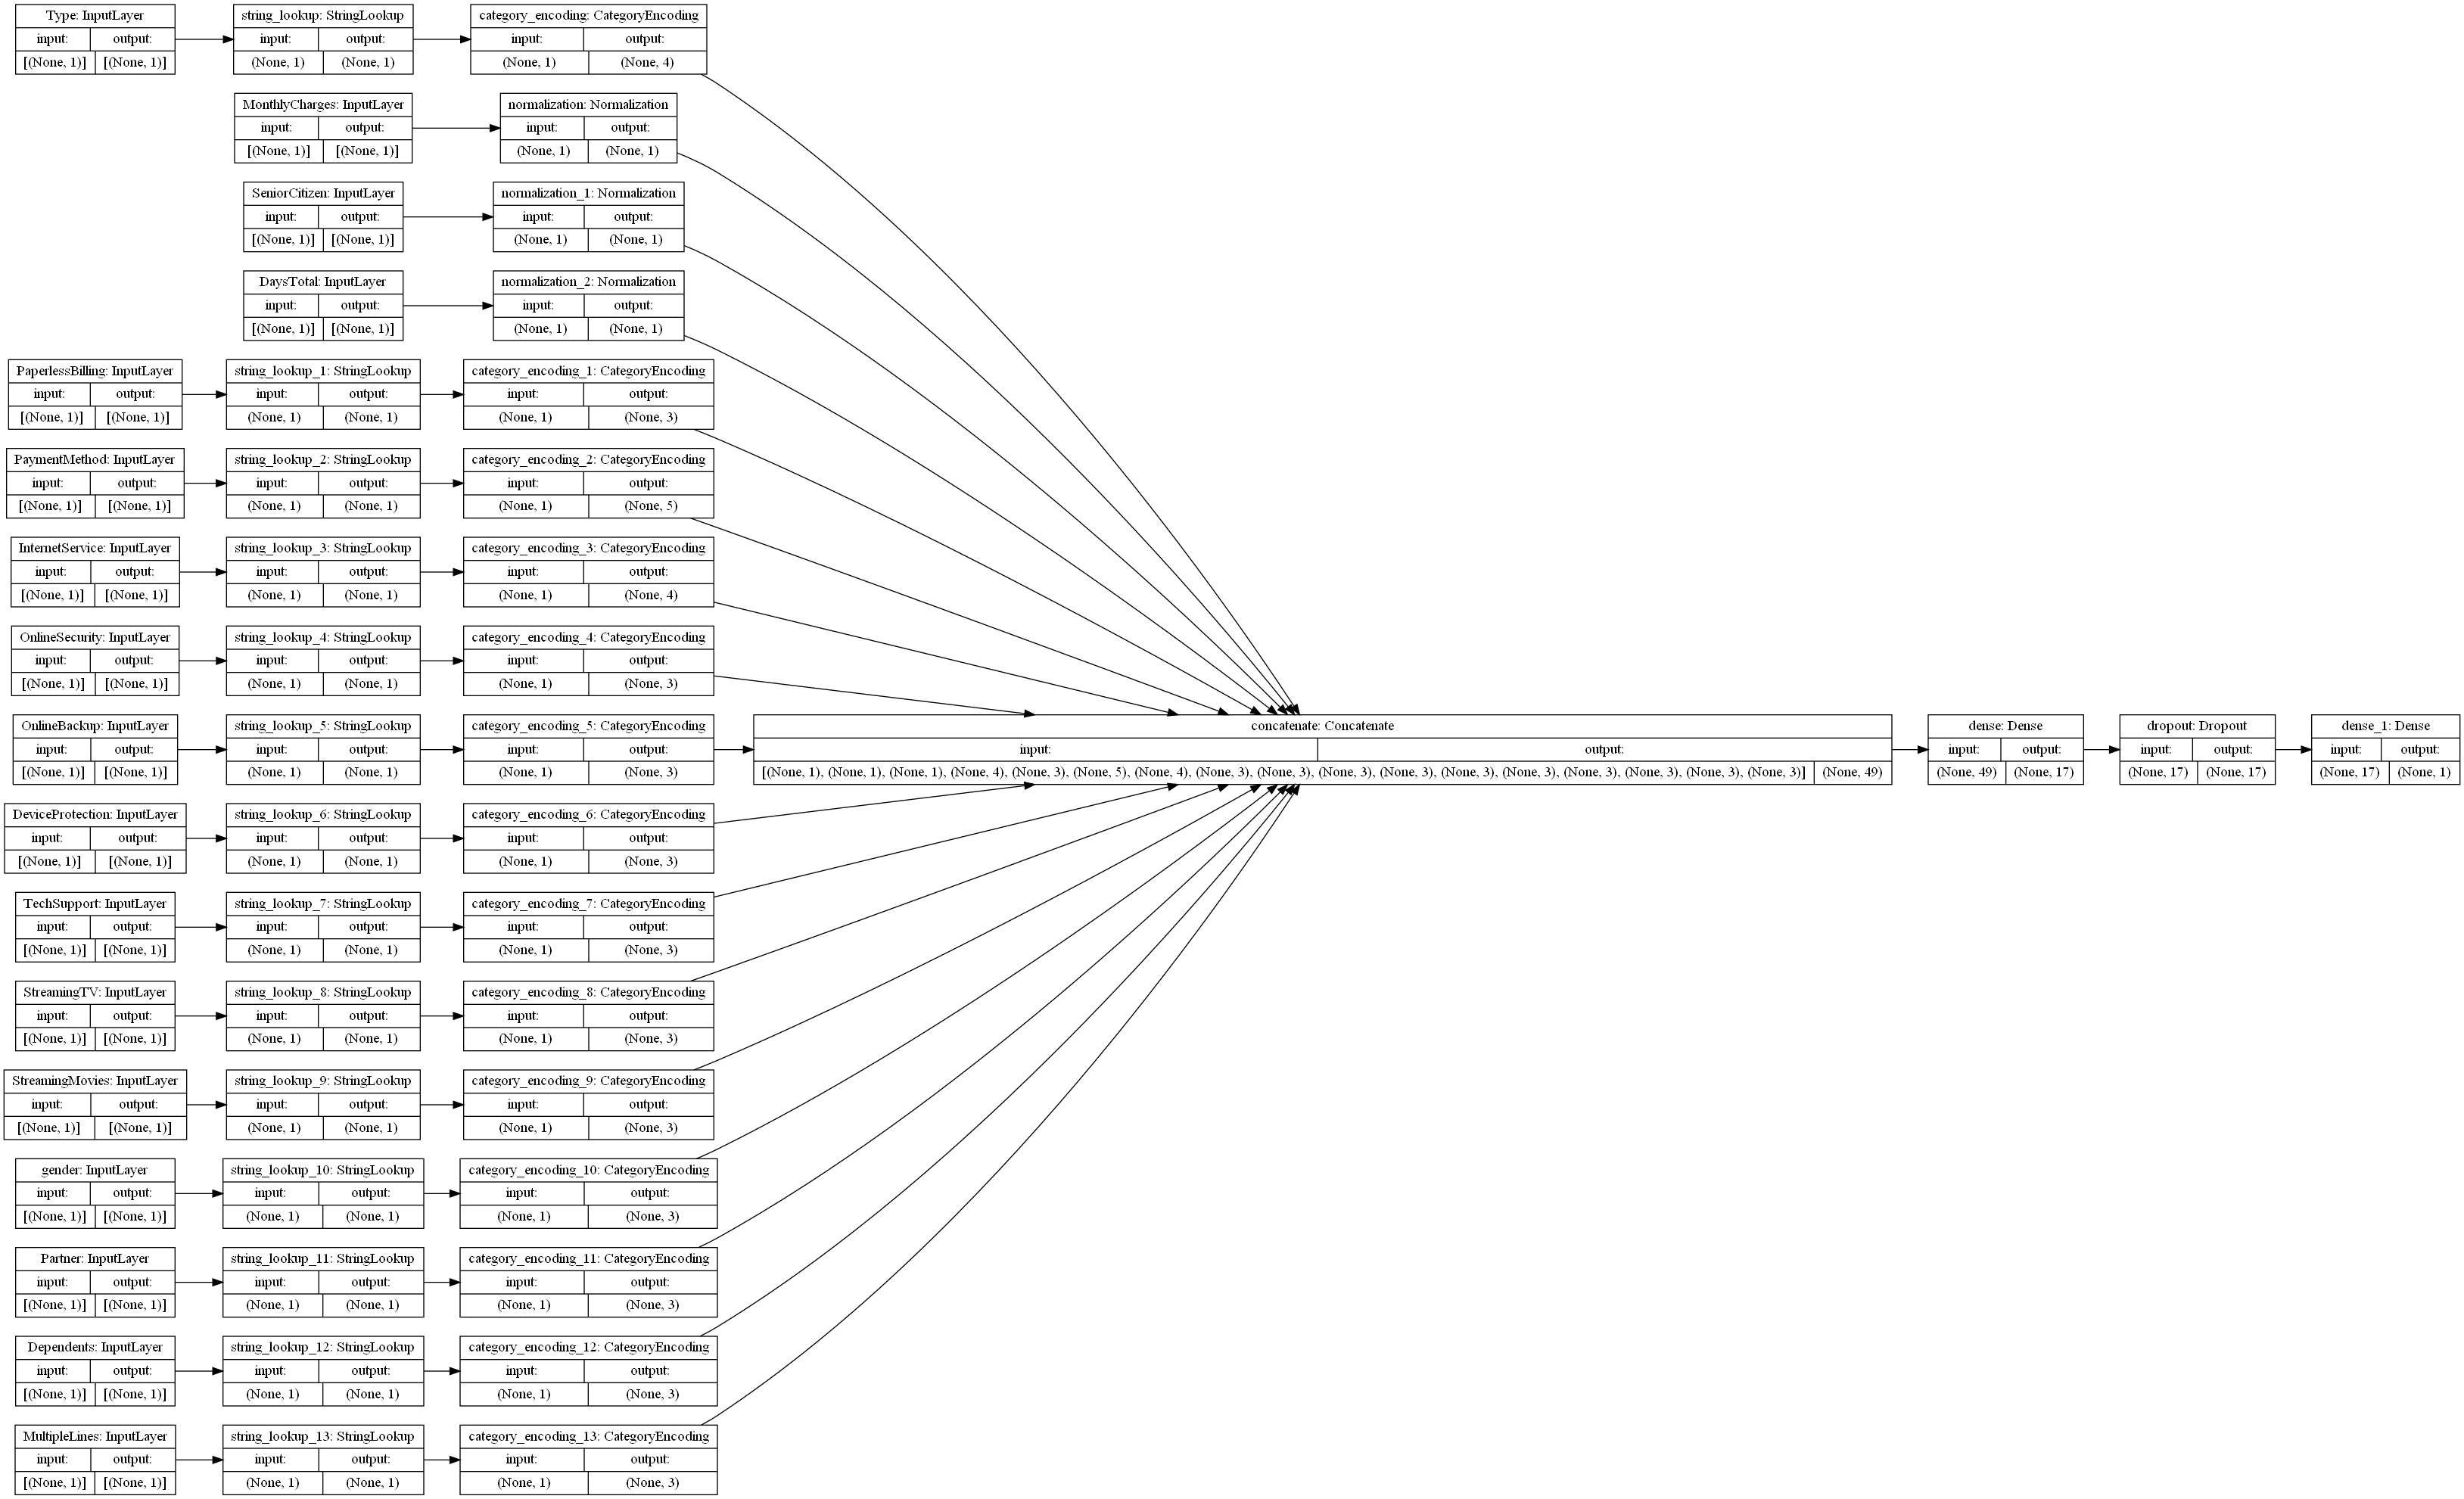

In [58]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [59]:
history = model.fit(train_ds, epochs=500, validation_data=val_ds, verbose=0, shuffle=True)

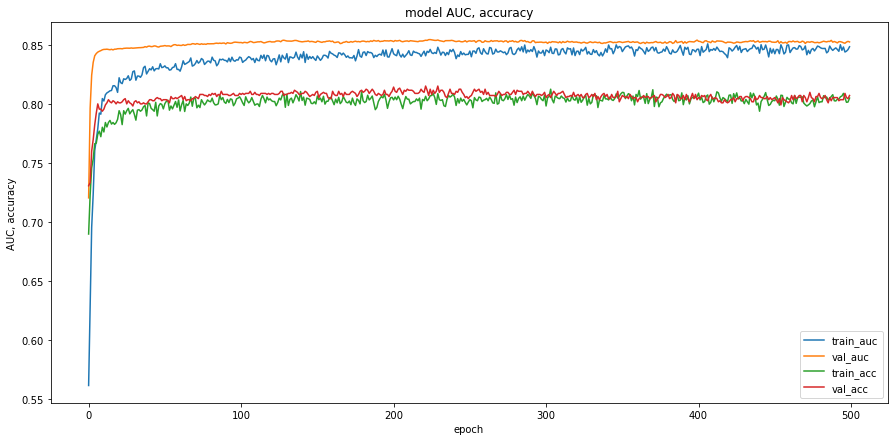

In [60]:
plt.figure(figsize=(15, 7))
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model AUC, accuracy')
plt.ylabel('AUC, accuracy')
plt.xlabel('epoch')
plt.legend(['train_auc','val_auc', 'train_acc','val_acc'], loc='lower right')
plt.show()

In [61]:
train_acc = model.evaluate(train_ds, verbose=2)
test_acc = model.evaluate(test_ds, verbose=2)

18/18 - 0s - loss: 0.3960 - auc: 0.8637 - accuracy: 0.8176
6/6 - 0s - loss: 0.4067 - auc: 0.8541 - accuracy: 0.7932


In [62]:
print('Train AUC-ROC: %.3f, Test AUC-ROC: %.3f' % (train_acc[1], test_acc[1]))

Train AUC-ROC: 0.864, Test AUC-ROC: 0.854


In [63]:
y_pred_proba = model.predict(test_ds)

In [64]:
threshold = 0.4
y_pred = y_pred_proba.copy()
y_pred[y_pred <= threshold] = 0
y_pred[y_pred > threshold] = 1

In [65]:
y_test = test['target']

In [66]:
roc_auc = roc_auc_score(y_test,  y_pred_proba)
acc = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = precision_score(y_test, y_pred)

In [67]:
table_result_keras = []
table_result_keras.append([roc_auc, acc, precision, recall, 'none', 'one hot', 0, 0, 
                            'Keras', 'Keras', 'Keras', 
                            model, model])

In [68]:
table_result_all = table_result.append(pd.DataFrame(table_result_keras, columns=list(table_result)), ignore_index=True)

In [69]:
table_result_all.sort_values(by='roc_auc', ascending=False, inplace=True)
table_result_all 

,roc_auc,accuracy,precision,recall,sampling,encoding,grid time(mean fold time),predict time,label,module,model,optimal_parameters,model_obj
3,0.921071,0.873490,0.766234,0.766234,none,ordinal,78.120832,0.043985,CatBoost,catboost,CatBoostClassifier,"{'classifier__auto_class_weights': 'Balanced',...","(ColumnTransformer(transformers=[('num',\n ..."
1,0.911794,0.852168,0.723785,0.723785,none,ordinal,1.943889,0.063829,LightGBM,lightgbm,LGBMClassifier,"{'classifier__class_weight': 'balanced', 'clas...","(ColumnTransformer(transformers=[('num',\n ..."
2,0.860021,0.789623,0.592751,0.592751,none,ordinal,1.436371,0.062930,Случайный лес,sklearn.ensemble,RandomForestClassifier,"{'classifier__class_weight': 'balanced', 'clas...","(ColumnTransformer(transformers=[('num',\n ..."
4,0.854061,0.796020,0.618919,0.618919,none,one hot,0.000000,0.000000,Keras,Keras,Keras,<keras.engine.functional.Functional object at ...,<keras.engine.functional.Functional object at ...
0,0.845449,0.739872,0.514431,0.514431,none,ordinal,0.524834,0.023936,Логистическая регрессия,sklearn.linear_model,LogisticRegression,{'classifier__class_weight': 'balanced'},"(ColumnTransformer(transformers=[('num',\n ..."


### Построение графиков

In [70]:
def plot_feature_importance(importance, names, model_type, ax):
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'], ax=ax)
    ax.set_title('Feature importance')
    ax.set_xlabel('feature importance')
    ax.set_ylabel('feature importance')
    
def plot_confusion_matrix_big(y_true, y_pred, ax, 
                              title=None,
                              cmap=plt.cm.Blues):
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = y_true.unique()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    fmt = 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                            ha="center", va="center",
                            color="white" if cm[i, j] > thresh else "black")
    ax.set_title('Confusion matrix')

   
def plot_confusion_matrix(predict_test, target_test):
        sns.heatmap(confusion_matrix(target_test, predict_test), 
            annot=True, fmt='d',cmap="Purples",cbar=False);

def plot_roc_auc(target, probabilities, ax):
    try:
        probabilities_one = probabilities[:, 1]
    except:
        probabilities_one = probabilities

    fpr, tpr, thresholds = roc_curve(target, probabilities_one)
    ax.plot([0, 1], [0, 1], linestyle='--')
    ax.plot(fpr, tpr, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("ROC-кривая")

def draw_all_plots(table_result, row, target_test, features_test, pipeline_col_labels):
    fig, ax = plt.subplots(1,3, figsize=(16, 5))
    try:
        plot_feature_importance(table_result['model_obj'][row][1].coef_[0], pipeline_col_labels, table_result['label'][row], ax[0])
    except:
        plot_feature_importance(table_result['model_obj'][row][1].feature_importances_, pipeline_col_labels, table_result['label'][row], ax[0])
    #plot_confusion_matrix(target_test, features_test, table_result['model_obj'][row])
    plot_confusion_matrix_big(target_test, table_result['model_obj'][row].predict(features_test), ax[1])
    probabilities_test = table_result['model_obj'][row].predict_proba(features_test)
    plot_roc_auc(target_test, probabilities_test, ax[2])
    fig.suptitle('Model: '+ table_result['label'][row], fontsize=16, y=1)

def draw_all_plots_keras(predict, predict_proba, target_test):
    fig, ax = plt.subplots(1,2, figsize=(16, 5))
    plot_confusion_matrix_big(target_test, predict, ax[0])
    plot_roc_auc(target_test, predict_proba, ax[1])
    fig.suptitle('Model: Keras', fontsize=16, y=1)

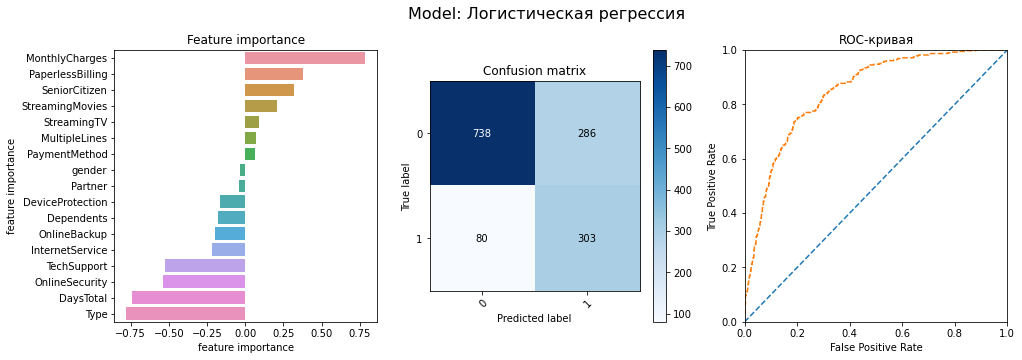

In [71]:
draw_all_plots(table_result_all , 0, target_test, features_test, pipeline_col_labels)

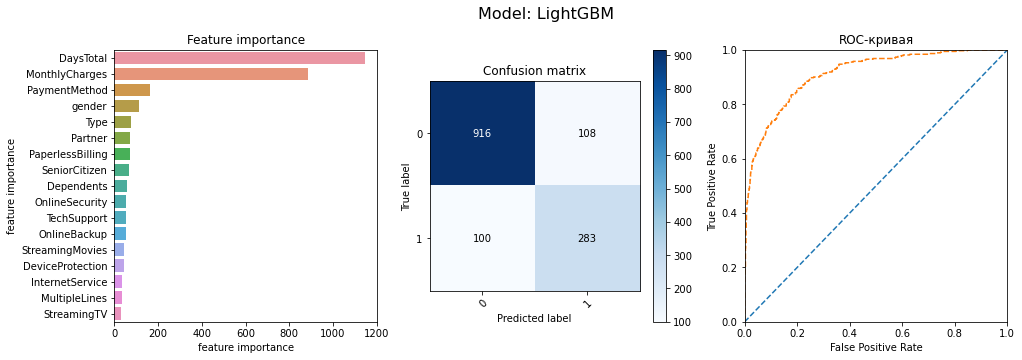

In [72]:
draw_all_plots(table_result_all , 1, target_test, features_test, pipeline_col_labels)

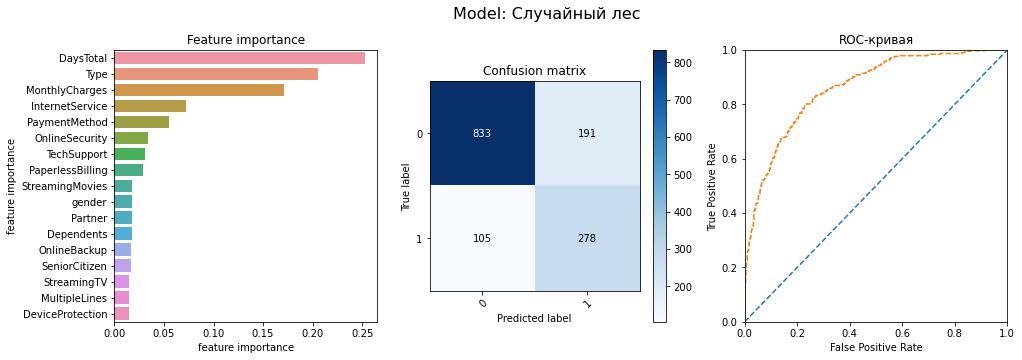

In [73]:
draw_all_plots(table_result_all , 2, target_test, features_test, pipeline_col_labels)

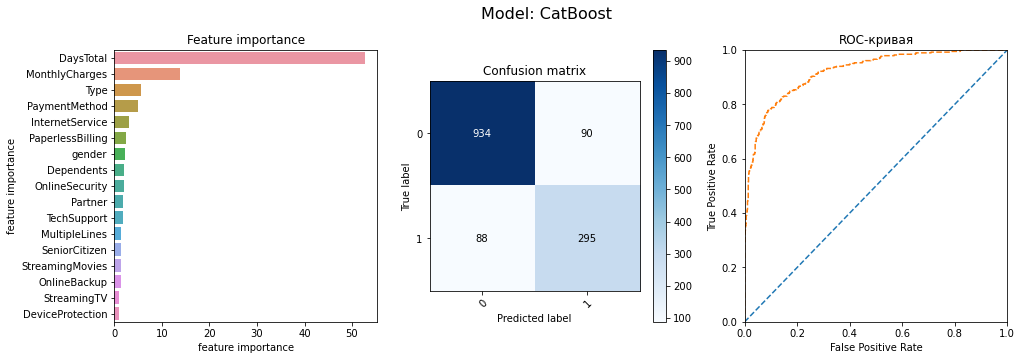

In [74]:
draw_all_plots(table_result_all , 3, target_test, features_test, pipeline_col_labels)

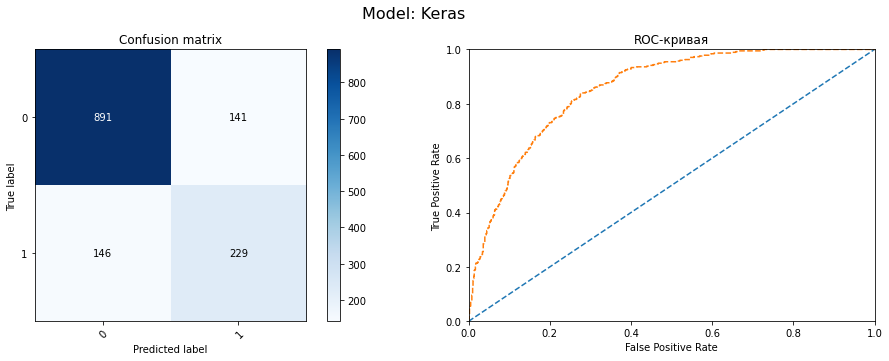

In [75]:
draw_all_plots_keras(y_pred, y_pred_proba, y_test)

### Анализ лучшей модели методами бибилотеки SHAP

In [76]:
best_model = table_result_all.iloc[0]

In [77]:
shap.initjs()

explainer = shap.TreeExplainer(best_model['model_obj'].named_steps['classifier'])
shap_values = explainer.shap_values(best_model['model_obj'][:-1].transform(features_train))

i = 4
shap.force_plot(explainer.expected_value, shap_values[0,:], features_train.iloc[0,:])

In [78]:
shap.force_plot(explainer.expected_value, shap_values[i], 
                features=features_train.iloc[i], 
                feature_names=pipeline_col_labels)

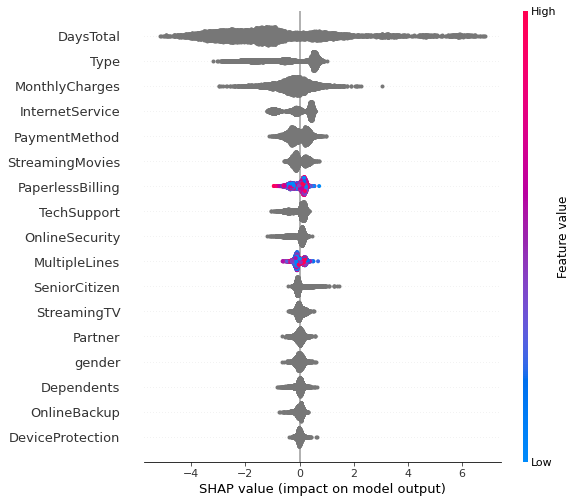

In [79]:
shap.summary_plot(shap_values, features=features_train, 
                  feature_names=pipeline_col_labels)

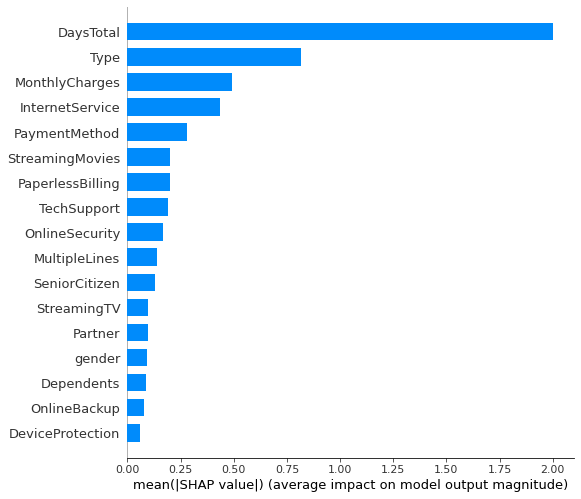

In [80]:
shap.summary_plot(shap_values, features=features_train, 
                  feature_names=pipeline_col_labels, plot_type='bar')

Выделим список самых важных фичей по мнению SHAP

In [81]:
importances = np.abs(shap_values).mean(0)
label = np.array(pipeline_col_labels)
df_shap_importances = pd.DataFrame({'cols': label, 'importances': importances}, columns=['cols', 'importances'])

### Построение моделей на основе признаков, выделенных SHAP

Попробуем построить модели на основе топ-10 важных фичей

In [82]:
df_shap_importances = df_shap_importances.sort_values(by='importances', ascending=False).head(10)

In [83]:
df_after_shap = df_all[df_shap_importances['cols'].append(pd.Series(['EndDate']))]
features_train_shap, target_train_shap, \
    features_test_shap, target_test_shap = split_data(df_after_shap, 'EndDate', rand_state, 1)

In [84]:
categorical_features = df_after_shap.drop(['EndDate'], axis=1).select_dtypes(include='object').columns
numeric_features = df_after_shap.drop(['EndDate'], axis=1).select_dtypes(include=['float64','int64']).columns
pipeline_col_labels_shap = list(numeric_features)  + list(categorical_features)
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('encoder', OrdinalEncoder())])
#categorical_transformer = Pipeline(steps=[('encoder', OneHotEncoder(drop='first'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

table_result_shap = choose_model(features_train_shap, target_train_shap, 
                                 features_test_shap, target_test_shap, 
                                 'EndDate', 'none', 'ordinal')

Gridsearch модели: Логистическая регрессия ...
Fitting 4 folds for each of 1 candidates, totalling 4 fits
Тест модели:  Логистическая регрессия ...
Gridsearch модели: LightGBM ...
Fitting 4 folds for each of 40 candidates, totalling 160 fits
Тест модели:  LightGBM ...
Gridsearch модели: Случайный лес ...
Fitting 4 folds for each of 20 candidates, totalling 80 fits
Тест модели:  Случайный лес ...
Gridsearch модели: CatBoost ...
Fitting 4 folds for each of 30 candidates, totalling 120 fits
Тест модели:  CatBoost ...


In [85]:
table_result_shap = table_result_shap.sort_values(by='roc_auc', ascending=False)
table_result_shap

,roc_auc,accuracy,precision,recall,sampling,encoding,grid time(mean fold time),predict time,label,module,model,optimal_parameters,model_obj
3,0.925433,0.874200,0.768229,0.768229,none,ordinal,55.905212,0.029920,CatBoost,catboost,CatBoostClassifier,"{'classifier__auto_class_weights': 'Balanced',...","(ColumnTransformer(transformers=[('num',\n ..."
1,0.914185,0.858564,0.735897,0.735897,none,ordinal,1.313026,0.053856,LightGBM,lightgbm,LGBMClassifier,"{'classifier__class_weight': 'balanced', 'clas...","(ColumnTransformer(transformers=[('num',\n ..."
2,0.864144,0.783937,0.581781,0.581781,none,ordinal,1.532645,0.045877,Случайный лес,sklearn.ensemble,RandomForestClassifier,"{'classifier__class_weight': 'balanced', 'clas...","(ColumnTransformer(transformers=[('num',\n ..."
0,0.843670,0.740583,0.515203,0.515203,none,ordinal,0.028210,0.017952,Логистическая регрессия,sklearn.linear_model,LogisticRegression,{'classifier__class_weight': 'balanced'},"(ColumnTransformer(transformers=[('num',\n ..."


## Выводы

Посмотрим еще раз на таблицу результатов и на график лучшей модели

In [86]:
table_result_all

,roc_auc,accuracy,precision,recall,sampling,encoding,grid time(mean fold time),predict time,label,module,model,optimal_parameters,model_obj
3,0.921071,0.873490,0.766234,0.766234,none,ordinal,78.120832,0.043985,CatBoost,catboost,CatBoostClassifier,"{'classifier__auto_class_weights': 'Balanced',...","(ColumnTransformer(transformers=[('num',\n ..."
1,0.911794,0.852168,0.723785,0.723785,none,ordinal,1.943889,0.063829,LightGBM,lightgbm,LGBMClassifier,"{'classifier__class_weight': 'balanced', 'clas...","(ColumnTransformer(transformers=[('num',\n ..."
2,0.860021,0.789623,0.592751,0.592751,none,ordinal,1.436371,0.062930,Случайный лес,sklearn.ensemble,RandomForestClassifier,"{'classifier__class_weight': 'balanced', 'clas...","(ColumnTransformer(transformers=[('num',\n ..."
4,0.854061,0.796020,0.618919,0.618919,none,one hot,0.000000,0.000000,Keras,Keras,Keras,<keras.engine.functional.Functional object at ...,<keras.engine.functional.Functional object at ...
0,0.845449,0.739872,0.514431,0.514431,none,ordinal,0.524834,0.023936,Логистическая регрессия,sklearn.linear_model,LogisticRegression,{'classifier__class_weight': 'balanced'},"(ColumnTransformer(transformers=[('num',\n ..."


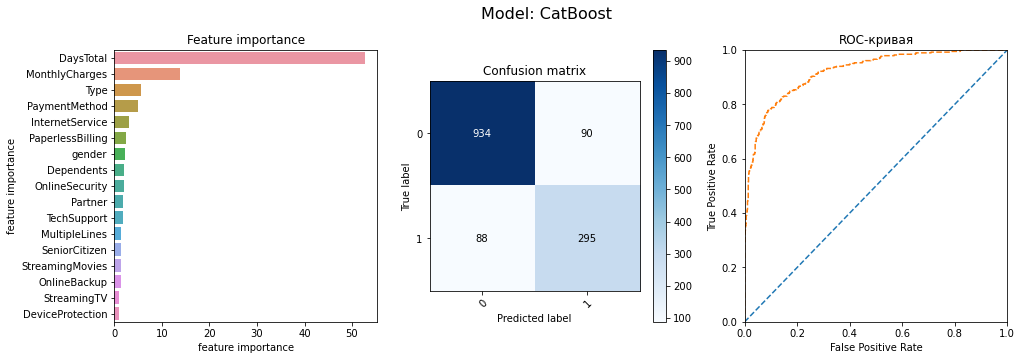

In [87]:
draw_all_plots(table_result_all, 3, target_test, features_test, pipeline_col_labels)

Видно, что из всех использующихся моделей "победил" CatBoost со значением <b>ROC-AUC=0.921</b>. У него есть минусы в виде долгого времени подбора оптимальных гипрепараметров и относительно долгого времени предсказания. При консультации с бизнесом можно предположить, что в ряде условий (например ограничение по производительности, необходимость частого обучения или использования в реальном времени) можно заменить модель на LGBM, т.к. разница в целевой метрике незначительная, но есть пруимущества в плане производительности.

Если рассматривать использования нейронных сетей для бинарной классификации на табличных данных, то тут явно своеобразный "оверкилл", т.к. метрика еле вытягивает (или даже не вытягивает) выше логистической регрессии, а сложность построения и обучения выше чем у "классических" моделей.

Также в данном проекте мы рассмотрели возможность анализа признаков, которые больше всего влияют на результат предсказания. Для этого использовали библиотеку SHAP. Как результат можно взять ТОП (3, 5, 10) и представить бизнесу, как требующие особого внимания. Однако если "скормить" моделям только самые важные фичи, то метрики кардинально не меняются, поэтому данную методику в нашем случае можно не применять, если только для нас не является критичным время обучения/предсказания.

Не следует забывать, что при указании целевой метрики AUC-ROC нужно анализировать ряд других отдельных показателей в зависимости от конкретной задачи:
- accuracy (точность) показывает количество правильно проставленных меток класса. Очень простая метрика и позволяет быстро в первом приближении оценить качество модели. Но она не учитывает соотношения ложных срабатываний модели, что может быть критическим
- prescision (точность) показывает количество истинно положительных исходов из всего набора положительных меток. Важность этой метрики определяется тем, насколько высока для рассматриваемой задачи «цена» ложно положительного результата
- recall (полнота) определяет количество истинно положительных среди всех меток класса, которые были определены как «положительный». Необходимо уделить особое внимание этой оценке, когда в поставленной задаче ошибка нераспознания положительного класса высока

Тоесть в любом случае границы единственной поставленной целевой метрики не избавляют нас от дополнительного анализа, обусловленного спецификой и доменной областью задачи.

Для этого также можно использовать наглядные инструменты типа графиков confusion matrix(чем больше значений по диагонали слева направо, тем лучше), ROC-кривая(чем выше к левому верхнему углу кривая, тем лучше).

## Отчет

### По пунктам плана работ:
- <i>дополнительно поискать аномалии или выбросы</i>. Вполне возможно, что на этапе подготовки данных мы что-то упустили, можно посмотреть повнимательнее, если метрика будет плохой. <b>Выполнено: дополнительный анализ данных не потребовался, модель вполне работает и без этого</b>;<br>
- <i>закодировать фичи (Ordinal, OHE)</i>. В зависимости от выбора модели можно будет применить различные методы кодирования и посмотреть как это влияет на метрики. <b>Выполнено: в проекте применены все виды кодирования в зависимости от использованных моделей</b>;<br>
- <i>возможно применить скейлинг</i>. В зависимости от выбора модели можно будет применить скейлинг и посмотреть как это влияет на метрики. <b>Выполнено: скейлинг для численных признаков применен</b>; <br>
- <i>построить модель применив нужные метрики, достичь нужного значения</i>. Мы используем AUC-ROC плюс контроль по accuracy. <b>Выполнено: построены различные виды моделей, в т.ч. нейросети, проанализированы метрики, требуемый результат достигнут</b>; <br>
- <i>написать вывод</i>. <b>Выполнено: предоставлен развернутый вывод.</b><br>

### Возникшие трудности:

- При построении графиков feature importance не было учтено, что модель передается через препроцесор пайплайна и фичи при этом меняются местам, поэтому в начале возникали ошибки при определении важности признаков

- Построение нормальной нейронной сети заняло поределенное время, т.к. пришлось изучать дополнительные материалы


### Ключевые шаги проекта:
- предобработка данных;
- построение пайплайнов, выбор типа обработки фичей в проепроцессоре;
- выбор и обучение моделей;
- анализ моделей по метрикам и визуальной состовляющей (графикам);
- попытка улучшения модели с помощью SHAP;
- выводы.



### Итоговая модель:
<b>CatBoost</b>

Метрики:
- ROC-AUC: 0.921071
- Accuracy: 0.873490
- Precision: 0.766234
- Recall: 0.766234	